In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install scikit-surprise


Note: you may need to restart the kernel to use updated packages.


In [35]:


import pandas as pd
import numpy as np

from surprise import Dataset, Reader
from surprise.model_selection import KFold
from surprise import SVD, KNNBasic
from surprise import accuracy



ratings_path = "/kaggle/input/the-movies-dataset/ratings_small.csv"

ratings = pd.read_csv(ratings_path)

print(ratings.head())
print(ratings.dtypes)
print(ratings.shape)


   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
(100004, 4)


In [36]:
reader = Reader(rating_scale=(0.5, 5.0))  # ratings are between 0.5 and 5
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

def calc_mae_rmse(predictions):
    y_true = np.array([p.r_ui for p in predictions])
    y_pred = np.array([p.est   for p in predictions])
    
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return mae, rmse




Dataset and helper ready.


In [37]:

from surprise import SVD, KNNBasic

results_basic = {
    'PMF':    {'mae': [], 'rmse': []},
    'UserCF': {'mae': [], 'rmse': []},
    'ItemCF': {'mae': [], 'rmse': []}
}

for fold, (trainset, testset) in enumerate(kf.split(data), start=1):
    print(f"\n=== Fold {fold} ===")

    # ---- PMF (SVD) ----
    algo_pmf = SVD(random_state=0)
    algo_pmf.fit(trainset)
    preds_pmf = algo_pmf.test(testset)
    mae, rmse = calc_mae_rmse(preds_pmf)
    results_basic['PMF']['mae'].append(mae)
    results_basic['PMF']['rmse'].append(rmse)
    print(f"PMF     -> MAE = {mae:.4f}, RMSE = {rmse:.4f}")

    sim_user = {'name': 'msd', 'user_based': True}
    algo_user = KNNBasic(sim_options=sim_user, k=20, min_k=1)
    algo_user.fit(trainset)
    preds_user = algo_user.test(testset)
    mae, rmse = calc_mae_rmse(preds_user)
    results_basic['UserCF']['mae'].append(mae)
    results_basic['UserCF']['rmse'].append(rmse)
    print(f"User-CF -> MAE = {mae:.4f}, RMSE = {rmse:.4f}")

    sim_item = {'name': 'msd', 'user_based': False}
    algo_item = KNNBasic(sim_options=sim_item, k=20, min_k=1)
    algo_item.fit(trainset)
    preds_item = algo_item.test(testset)
    mae, rmse = calc_mae_rmse(preds_item)
    results_basic['ItemCF']['mae'].append(mae)
    results_basic['ItemCF']['rmse'].append(rmse)
    print(f"Item-CF -> MAE = {mae:.4f}, RMSE = {rmse:.4f}")

print("\n=== Average over 5 folds ===")
for model in results_basic:
    mae_mean = np.mean(results_basic[model]['mae'])
    rmse_mean = np.mean(results_basic[model]['rmse'])
    print(f"{model}: mean MAE = {mae_mean:.44f}, mean RMSE = {rmse_mean:.4f}")



=== Fold 1 ===
PMF     -> MAE = 0.6887, RMSE = 0.8969
Computing the msd similarity matrix...
Done computing similarity matrix.
User-CF -> MAE = 0.7381, RMSE = 0.9639
Computing the msd similarity matrix...
Done computing similarity matrix.
Item-CF -> MAE = 0.7287, RMSE = 0.9440

=== Fold 2 ===
PMF     -> MAE = 0.6904, RMSE = 0.8970
Computing the msd similarity matrix...
Done computing similarity matrix.
User-CF -> MAE = 0.7407, RMSE = 0.9683
Computing the msd similarity matrix...
Done computing similarity matrix.
Item-CF -> MAE = 0.7335, RMSE = 0.9506

=== Fold 3 ===
PMF     -> MAE = 0.6915, RMSE = 0.8962
Computing the msd similarity matrix...
Done computing similarity matrix.
User-CF -> MAE = 0.7419, RMSE = 0.9670
Computing the msd similarity matrix...
Done computing similarity matrix.
Item-CF -> MAE = 0.7339, RMSE = 0.9506

=== Fold 4 ===
PMF     -> MAE = 0.6933, RMSE = 0.8987
Computing the msd similarity matrix...
Done computing similarity matrix.
User-CF -> MAE = 0.7404, RMSE = 0.9

In [38]:

sim_metrics = ['cosine', 'msd', 'pearson']

sim_results = {
    'UserCF': {m: {'mae': [], 'rmse': []} for m in sim_metrics},
    'ItemCF': {m: {'mae': [], 'rmse': []} for m in sim_metrics},
}

for m in sim_metrics:
    print(f"\n=== Similarity: {m} ===")
    for fold, (trainset, testset) in enumerate(kf.split(data), start=1):
        print(f"  Fold {fold}")

        # ----- User-based CF -----
        sim_user = {'name': m, 'user_based': True}
        algo_user = KNNBasic(sim_options=sim_user, k=20, min_k=1)
        algo_user.fit(trainset)
        preds_user = algo_user.test(testset)
        mae_u, rmse_u = calc_mae_rmse(preds_user)
        sim_results['UserCF'][m]['mae'].append(mae_u)
        sim_results['UserCF'][m]['rmse'].append(rmse_u)

        # ----- Item-based CF -----
        sim_item = {'name': m, 'user_based': False}
        algo_item = KNNBasic(sim_options=sim_item, k=20, min_k=1)
        algo_item.fit(trainset)
        preds_item = algo_item.test(testset)
        mae_i, rmse_i = calc_mae_rmse(preds_item)
        sim_results['ItemCF'][m]['mae'].append(mae_i)
        sim_results['ItemCF'][m]['rmse'].append(rmse_i)

print("\n=== Average over 5 folds for each similarity ===")
for model in ['UserCF', 'ItemCF']:
    print(f"\n{model}:")
    for m in sim_metrics:
        mae_mean = np.mean(sim_results[model][m]['mae'])
        rmse_mean = np.mean(sim_results[model][m]['rmse'])
        print(f"  {m:7s} -> MAE = {mae_mean:.4f}, RMSE = {rmse_mean:.4f}")



=== Similarity: cosine ===
  Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
  Fold 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
  Fold 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
  Fold 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
  Fold 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

=== Similarity: msd ===
  Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing simila

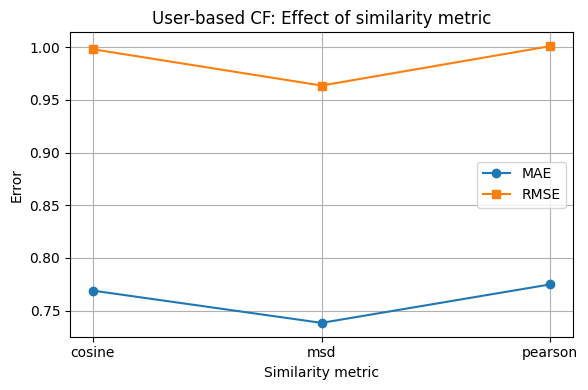

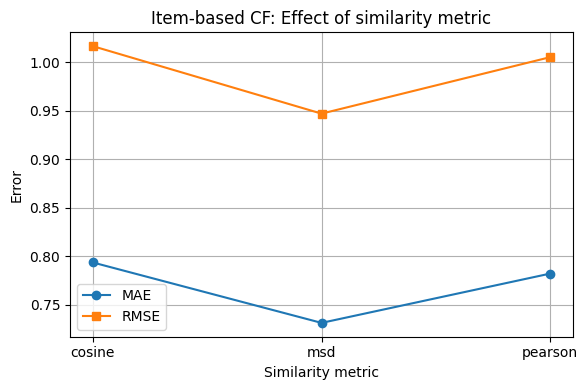

In [39]:
import matplotlib.pyplot as plt
import numpy as np


metrics = sim_metrics 

user_mae_means = [np.mean(sim_results['UserCF'][m]['mae'])  for m in metrics]
user_rmse_means = [np.mean(sim_results['UserCF'][m]['rmse']) for m in metrics]

item_mae_means = [np.mean(sim_results['ItemCF'][m]['mae'])  for m in metrics]
item_rmse_means = [np.mean(sim_results['ItemCF'][m]['rmse']) for m in metrics]

x = np.arange(len(metrics))

plt.figure(figsize=(6, 4))
plt.plot(x, user_mae_means,  marker='o', label='MAE')
plt.plot(x, user_rmse_means, marker='s', label='RMSE')
plt.xticks(x, metrics)
plt.xlabel('Similarity metric')
plt.ylabel('Error')
plt.title('User-based CF: Effect of similarity metric')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(x, item_mae_means,  marker='o', label='MAE')
plt.plot(x, item_rmse_means, marker='s', label='RMSE')
plt.xticks(x, metrics)
plt.xlabel('Similarity metric')
plt.ylabel('Error')
plt.title('Item-based CF: Effect of similarity metric')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:

k_values = [5, 10, 20, 40, 60]

k_results = {
    'UserCF': {K: {'mae': [], 'rmse': []} for K in k_values},
    'ItemCF': {K: {'mae': [], 'rmse': []} for K in k_values},
}

for K in k_values:
    print(f"\n=== K = {K} ===")
    for fold, (trainset, testset) in enumerate(kf.split(data), start=1):
        print(f"  Fold {fold}")

        sim_user = {'name': 'msd', 'user_based': True}
        algo_user = KNNBasic(sim_options=sim_user, k=K, min_k=1)
        algo_user.fit(trainset)
        preds_user = algo_user.test(testset)
        mae_u, rmse_u = calc_mae_rmse(preds_user)
        k_results['UserCF'][K]['mae'].append(mae_u)
        k_results['UserCF'][K]['rmse'].append(rmse_u)

        sim_item = {'name': 'msd', 'user_based': False}
        algo_item = KNNBasic(sim_options=sim_item, k=K, min_k=1)
        algo_item.fit(trainset)
        preds_item = algo_item.test(testset)
        mae_i, rmse_i = calc_mae_rmse(preds_item)
        k_results['ItemCF'][K]['mae'].append(mae_i)
        k_results['ItemCF'][K]['rmse'].append(rmse_i)

print("\n=== Average over 5 folds for each K ===")
for model in ['UserCF', 'ItemCF']:
    print(f"\n{model}:")
    for K in k_values:
        mae_mean = np.mean(k_results[model][K]['mae'])
        rmse_mean = np.mean(k_results[model][K]['rmse'])
        print(f"  K={K:2d} -> MAE = {mae_mean:.4f}, RMSE = {rmse_mean:.4f}")



=== K = 5 ===
  Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
  Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
  Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
  Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
  Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

=== K = 10 ===
  Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
  Fold 2
Computing the msd similarity m

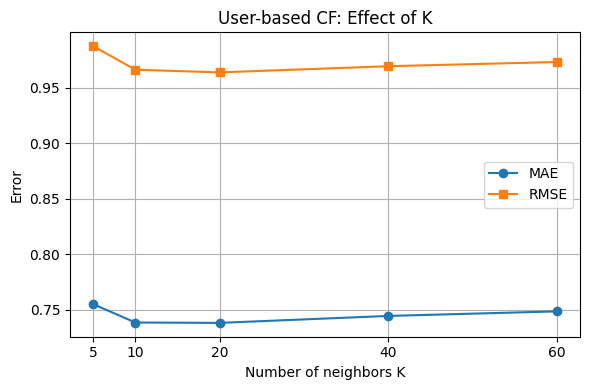

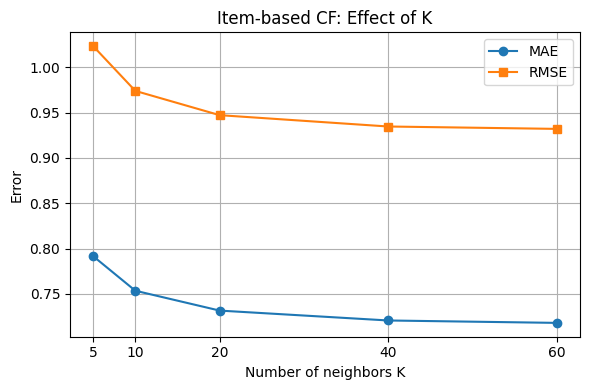

Best K for UserCF (lowest RMSE): K = 20
Best K for ItemCF (lowest RMSE): K = 60


In [41]:

import matplotlib.pyplot as plt
import numpy as np

Ks = k_values  # [5, 10, 20, 40, 60]

# ---- Compute mean errors for each K ----
user_mae_means  = [np.mean(k_results['UserCF'][K]['mae'])  for K in Ks]
user_rmse_means = [np.mean(k_results['UserCF'][K]['rmse']) for K in Ks]

item_mae_means  = [np.mean(k_results['ItemCF'][K]['mae'])  for K in Ks]
item_rmse_means = [np.mean(k_results['ItemCF'][K]['rmse']) for K in Ks]

# ---- Plot 1: User-based CF ----
plt.figure(figsize=(6, 4))
plt.plot(Ks, user_mae_means,  marker='o', label='MAE')
plt.plot(Ks, user_rmse_means, marker='s', label='RMSE')
plt.xlabel('Number of neighbors K')
plt.ylabel('Error')
plt.title('User-based CF: Effect of K')
plt.xticks(Ks)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot 2: Item-based CF ----
plt.figure(figsize=(6, 4))
plt.plot(Ks, item_mae_means,  marker='o', label='MAE')
plt.plot(Ks, item_rmse_means, marker='s', label='RMSE')
plt.xlabel('Number of neighbors K')
plt.ylabel('Error')
plt.title('Item-based CF: Effect of K')
plt.xticks(Ks)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---- Print best K (by RMSE) for 2(g) ----
best_user_idx = int(np.argmin(user_rmse_means))
best_item_idx = int(np.argmin(item_rmse_means))

print(f"Best K for UserCF (lowest RMSE): K = {Ks[best_user_idx]}")
print(f"Best K for ItemCF (lowest RMSE): K = {Ks[best_item_idx]}")
